In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# This code demonstrates how to fine-tune Vision Transformer (ViT) and SWIN models on the CIFAR-10 dataset and apply Grad-CAM visualization.

## 1. Setup Environment

# !pip install torch torchvision timm pytorch-gradcam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
#!pip show pytorch-gradcam
#!ls /usr/local/lib/python3.11/dist-packages/

## 2. Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

## 3. Data Preparation

# Set up normalization based on the cifar10 dataset
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
size = (224, 224)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [3]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

## 4. Model Setup

# Load pre-trained models
swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=10)


# Modify classification heads
# swin_model.head = nn.Linear(swin_model.head.in_features, 10)

# # multi GPU setup
# swin_model = nn.DataParallel(swin_model)

# # Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [4]:
from tqdm import tqdm
from torch.amp import autocast

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    eval_losses = []
    eval_accuracies = []
    lrs = [] 
    best_acc = 0.0

    scaler = torch.amp.GradScaler(device='cuda', enabled=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 記錄當前學習率
        current_lr = scheduler.get_last_lr()[0]
        lrs.append(current_lr)

        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda', enabled=True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        avg_train_loss = running_loss / len(trainloader)
        train_acc = correct / total * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch+1}, LR: {current_lr:.6e}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}")

        # Evaluate
        eval_loss, eval_acc = evaluate_model(model, testloader, criterion)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_acc)

        if eval_acc > best_acc:
            best_acc = eval_acc
            torch.save(model.state_dict(), "./swin/best_swin_model.pth")
            print("🧠 Best model updated.")

    return train_losses, train_accuracies, eval_losses, eval_accuracies, lrs
    
def evaluate_model(model, testloader, criterion):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Eval Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [5]:
# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
swin_optimizer = optim.AdamW(swin_model.parameters(), lr=5e-5) # 7e-4, 5e-5

# Train models
print("Training Swin Transformer...")
train_losses, train_accuracies, eval_losses, eval_accuracies, lrs = train_model(swin_model, trainloader, testloader, criterion, swin_optimizer, num_epochs=10)

Training Swin Transformer...


Epoch 1: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]


Epoch 1, LR: 5.000000e-05, Train Loss: 0.1400, Train Acc: 95.97


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.93it/s]


Eval Loss: 0.0541, Accuracy: 98.23%
🧠 Best model updated.


Epoch 2: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]


Epoch 2, LR: 4.877641e-05, Train Loss: 0.0458, Train Acc: 98.49


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Eval Loss: 0.0496, Accuracy: 98.62%
🧠 Best model updated.


Epoch 3: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]


Epoch 3, LR: 4.522542e-05, Train Loss: 0.0266, Train Acc: 99.14


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Eval Loss: 0.0558, Accuracy: 98.41%


Epoch 4: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


Epoch 4, LR: 3.969463e-05, Train Loss: 0.0198, Train Acc: 99.37


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Eval Loss: 0.0577, Accuracy: 98.36%


Epoch 5: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


Epoch 5, LR: 3.272542e-05, Train Loss: 0.0132, Train Acc: 99.57


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Eval Loss: 0.0585, Accuracy: 98.51%


Epoch 6: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]


Epoch 6, LR: 2.500000e-05, Train Loss: 0.0107, Train Acc: 99.67


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Eval Loss: 0.0578, Accuracy: 98.68%
🧠 Best model updated.


Epoch 7: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


Epoch 7, LR: 1.727458e-05, Train Loss: 0.0062, Train Acc: 99.78


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Eval Loss: 0.0595, Accuracy: 98.70%
🧠 Best model updated.


Epoch 8: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


Epoch 8, LR: 1.030537e-05, Train Loss: 0.0041, Train Acc: 99.88


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.93it/s]


Eval Loss: 0.0514, Accuracy: 98.87%
🧠 Best model updated.


Epoch 9: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]


Epoch 9, LR: 4.774575e-06, Train Loss: 0.0028, Train Acc: 99.93


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Eval Loss: 0.0512, Accuracy: 98.89%
🧠 Best model updated.


Epoch 10: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]


Epoch 10, LR: 1.223587e-06, Train Loss: 0.0017, Train Acc: 99.96


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Eval Loss: 0.0516, Accuracy: 98.93%
🧠 Best model updated.


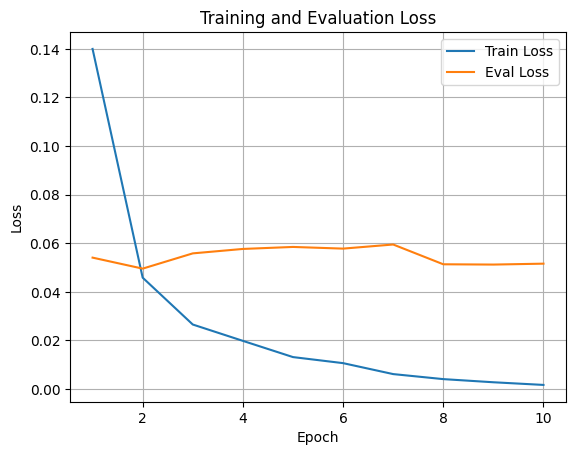

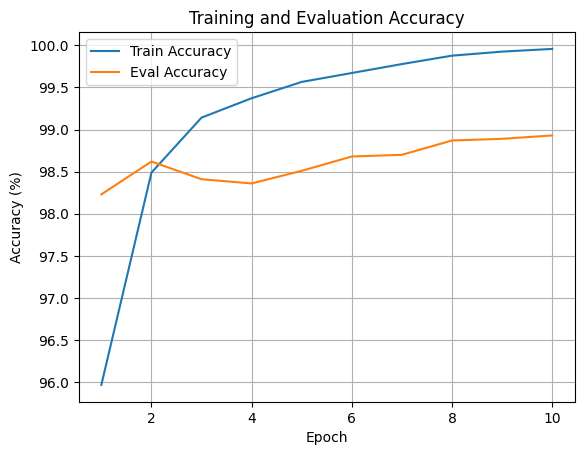

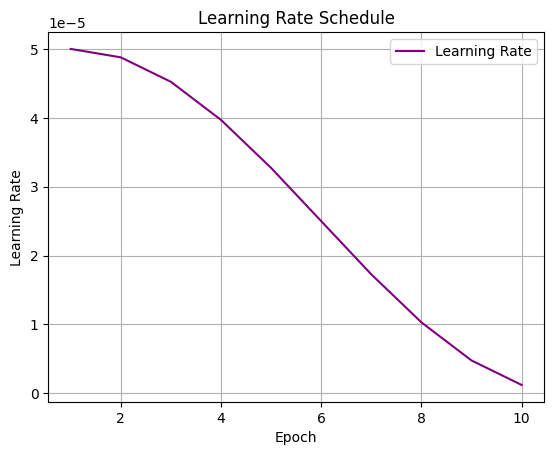

In [6]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.savefig("./swin/loss_curve.png")

plt.figure()
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, eval_accuracies, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Evaluation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("./swin/accuracy_curve.png")

plt.figure()
plt.plot(epochs, lrs, label='Learning Rate', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.savefig("./swin/lr_schedule.png")

plt.show()

📦 Total Parameters: 86.75M
⚙️ FLOPs: 15.17 GFLOPs
⏱️ Avg Inference Time: 30.79 ms/image
📊 Max GPU Memory Usage: 4301.61 MB


Testing: 100%|██████████| 79/79 [00:28<00:00,  2.80it/s]


✅ Accuracy: 0.9893
❌ Top-1 Error Rate: 0.0107
📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.99      1.00      1.00      1000
  automobile       0.99      0.99      0.99      1000
        bird       0.99      0.99      0.99      1000
         cat       0.97      0.97      0.97      1000
        deer       0.99      0.99      0.99      1000
         dog       0.98      0.97      0.98      1000
        frog       1.00      1.00      1.00      1000
       horse       1.00      0.99      1.00      1000
        ship       1.00      1.00      1.00      1000
       truck       0.99      0.98      0.99      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



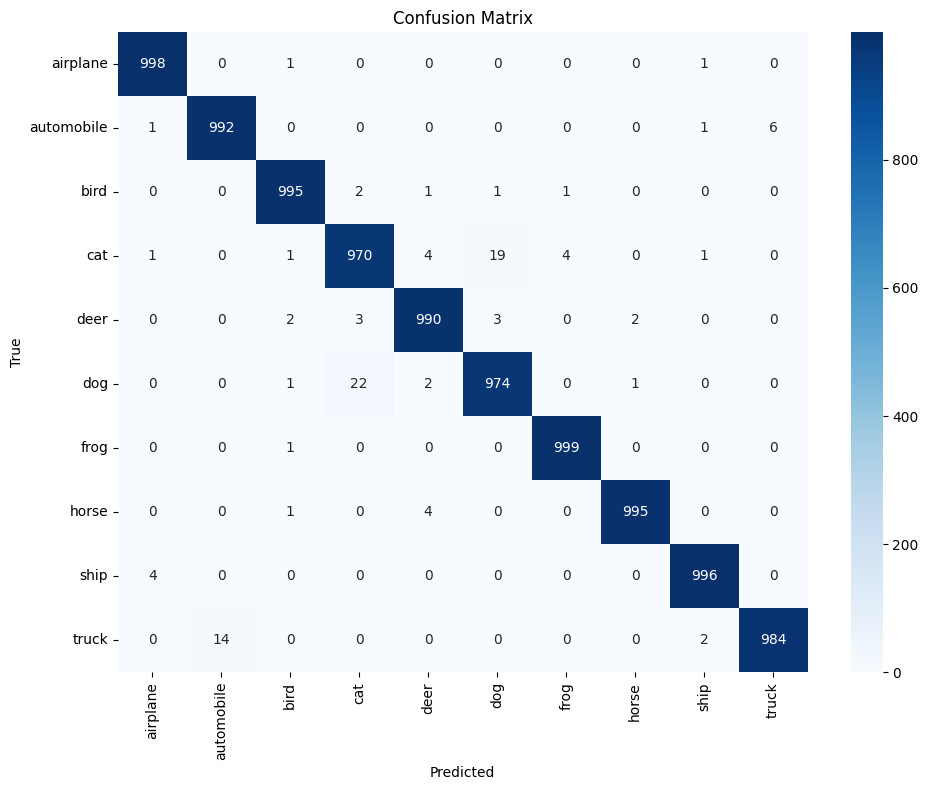

In [7]:
from timm import create_model
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from thop import profile
import time

# Load model
swin_best_model = create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=10)
swin_best_model.load_state_dict(torch.load('./swin/best_swin_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_best_model.to(device)
swin_best_model.eval()

# Measure Params (M)
total_params = sum(p.numel() for p in swin_best_model.parameters() if p.requires_grad)
print(f"📦 Total Parameters: {total_params/1e6:.2f}M")

# Measure FLOPs
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(swin_best_model, inputs=(dummy_input,), verbose=False)
print(f"⚙️ FLOPs: {flops / 1e9:.2f} GFLOPs")

# Measure Inference Time
n_test_samples = 100
n_measured = 0
total_time = 0.0

with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        if n_measured >= n_test_samples:
            break
        for img in images:
            if n_measured >= n_test_samples:
                break
            img = img.unsqueeze(0)
            start = time.time()
            _ = swin_best_model(img)
            total_time += time.time() - start
            n_measured += 1

avg_infer_time = total_time / n_measured * 1000  # ms
print(f"⏱️ Avg Inference Time: {avg_infer_time:.2f} ms/image")

# Measure Max GPU Memory Usage
torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        _ = swin_best_model(images)
        break  # Just 1 batch for GPU usage test
max_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB
print(f"📊 Max GPU Memory Usage: {max_memory:.2f} MB")

# Inference for accuracy
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing"):
        images = images.cuda()
        labels = labels.cuda()
        outputs = swin_best_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
top1_error = 1 - acc

print(f"✅ Accuracy: {acc:.4f}")
print(f"❌ Top-1 Error Rate: {top1_error:.4f}")

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=testset.classes))

cfm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cfm, annot=True, fmt="d", cmap='Blues',
            xticklabels=testset.classes,
            yticklabels=testset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("./swin/confusion_matrix.png")
plt.show()

        (1): SwinTransformerBlock(
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): DropPath(drop_prob=0.100)
          (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path2): DropPath(drop_prob=0.100)
        )
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (head): ClassifierHead(
    (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
    (drop): Dropout(p=0.0, inplace=False)
    (fc): Linear(in_features=1024, out_features=10, bias=True)
    (flatten): Identity()
  )
)

In [31]:
hook_handle.remove()

[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])


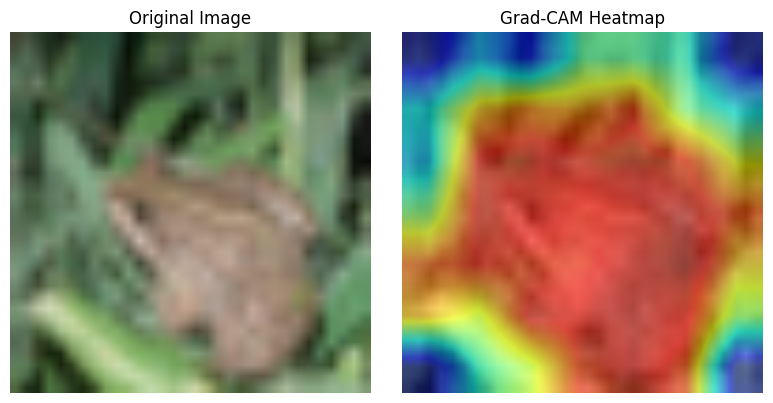

[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
Predicted class: frog
Confidence: 100.00%


In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

# -----------------------------
# Normalization info for CIFAR-10
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

# -----------------------------
# Grad-CAM reshape transform for Swin
def swin_reshape_transform(tensor):
    # [
    # ] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
    return tensor.permute(0, 3, 1, 2).contiguous()  # → [B, C, H, W]
# -----------------------------

def unnormalize_img(img_tensor):
    if len(img_tensor.shape) == 4:
        img_tensor = img_tensor[0]
    
    img = img_tensor.cpu().numpy()
    mean_np = np.array(mean).reshape(3, 1, 1)
    std_np = np.array(std).reshape(3, 1, 1)
    
    # Unnormalize: img = img * std + mean
    img = img * std_np + mean_np
    
    # Clip to valid range for display
    img = np.clip(img, 0, 1)
    
    # Convert from CHW to HWC format
    img = img.transpose(1, 2, 0).astype(np.float32)
    
    return img

# -----------------------------
# Sample a random test image
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
selected_idx = 4
images, labels = next(iter(testloader))
single_img = images[selected_idx:selected_idx+1].to(device)
true_label = labels[selected_idx]
img_class = classes[true_label]
# -----------------------------
# Pick target layer
if isinstance(swin_model, torch.nn.DataParallel):
    target_layer = swin_model.module.layers[-1].blocks[-1].norm1
else:
    target_layer = swin_model.layers[-1].blocks[-1].norm1

# -----------------------------
# Create GradCAM
swin_cam = GradCAM(
    model=swin_model,
    target_layers=[target_layer],
    reshape_transform=swin_reshape_transform
)

# -----------------------------
# Generate Grad-CAM heatmap
grayscale_cam = swin_cam(input_tensor=single_img, targets=None)[0]
original_img = unnormalize_img(single_img)
cam_img = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

# -----------------------------
# Plot original and Grad-CAM side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_img)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.savefig("./swin/gradcam.png")

plt.tight_layout()
plt.show()

# Make prediction
with torch.no_grad():
    outputs = swin_model(single_img)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
    top_prob, top_class = torch.max(probabilities, 0)
    print(f"Predicted class: {classes[top_class]}")
    print(f"Confidence: {top_prob.item()*100:.2f}%")

Random indices: [34, 16, 65, 30, 126]
hi
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])


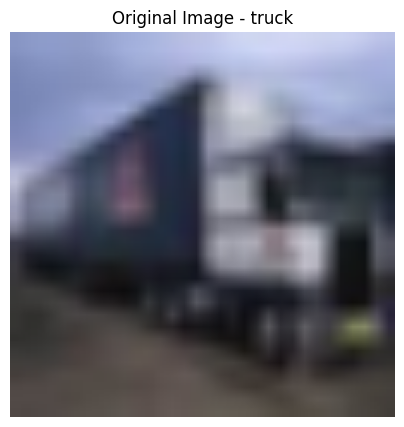

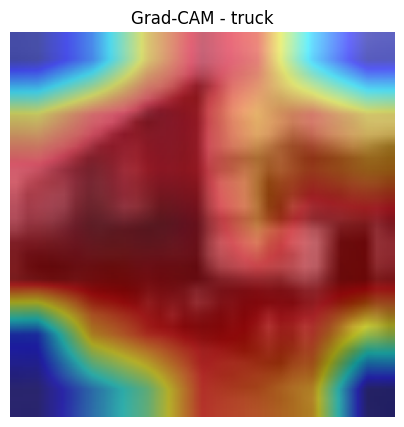

[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
Predicted class: truck
Confidence: 100.00%
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])


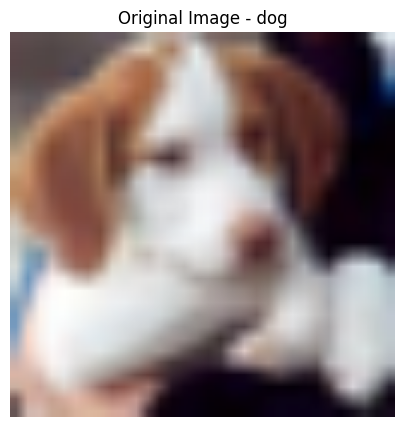

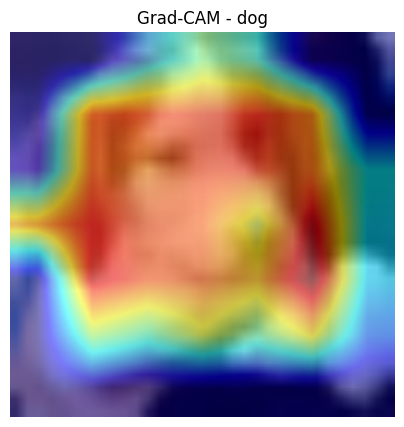

[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
Predicted class: dog
Confidence: 100.00%
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])


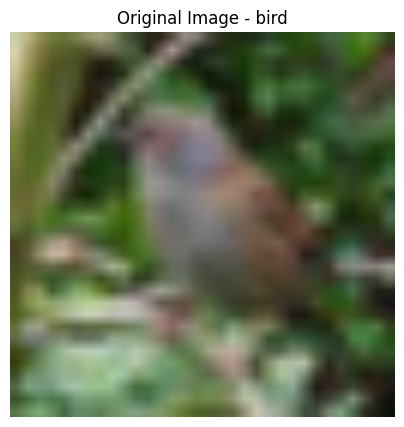

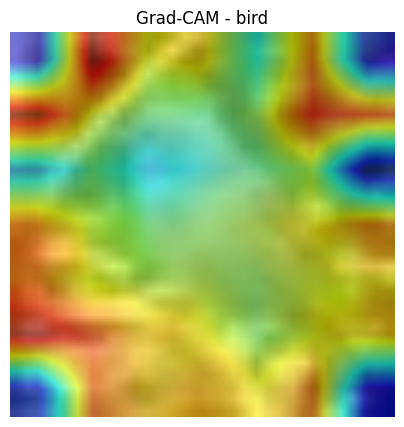

[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
Predicted class: bird
Confidence: 100.00%
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])


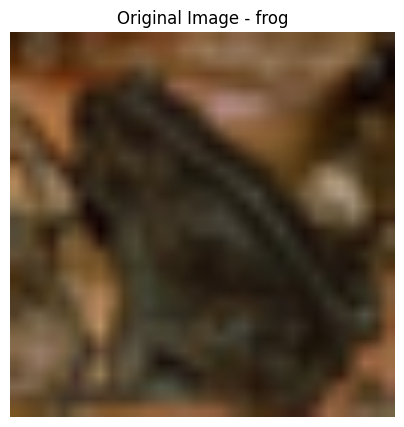

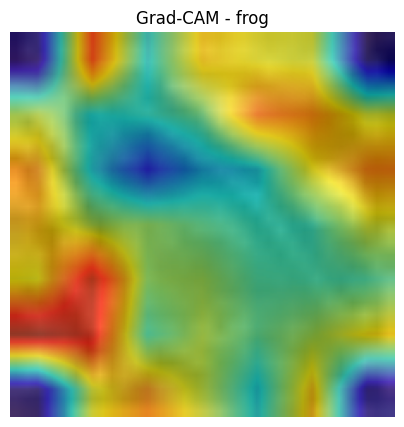

[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
Predicted class: frog
Confidence: 100.00%
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])


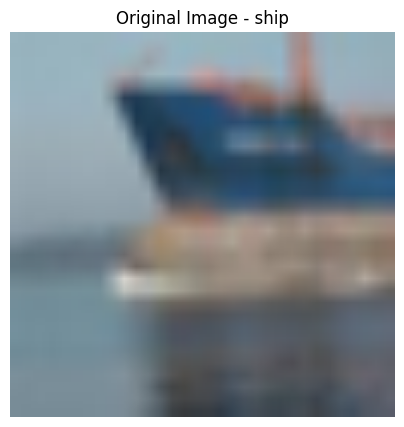

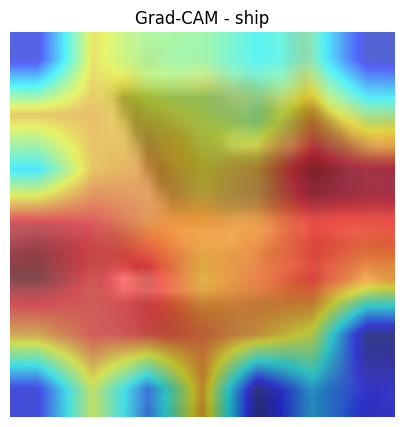

[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
[HOOK] Output shape of LayerNorm: torch.Size([1, 7, 7, 1024])
Predicted class: ship
Confidence: 100.00%
all image have been saved to ./swin/random_images
Already saved:
  - bird_gradcam_65.png
  - bird_original_65.png
  - dog_gradcam_16.png
  - dog_original_16.png
  - frog_gradcam_30.png
  - frog_original_30.png
  - ship_gradcam_126.png
  - ship_original_126.png
  - truck_gradcam_34.png
  - truck_original_34.png


In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

output_dir = "./swin/random_images"
os.makedirs(output_dir, exist_ok=True)


images, labels = next(iter(testloader))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

seed = 1
random.seed(seed)
total_images = len(images)
random_indices = random.sample(range(total_images), 5)
print(f"Random indices: {random_indices}")

target_layer = swin_model.layers[-1].blocks[-1].norm1
print("hi")
cam = GradCAM(model=swin_model, 
              target_layers=[target_layer], 
              reshape_transform=swin_reshape_transform)

for idx in random_indices:
    single_img = images[idx:idx+1].to(device)
    img_class = classes[labels[idx]]

    grayscale_cam = cam(input_tensor=single_img, targets=None)[0]
    original_img = unnormalize_img(single_img)
    
    cam_img = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(original_img)
    plt.title(f"Original Image - {img_class}")
    plt.axis('off')
    plt.savefig(f"{output_dir}/{img_class}_original_{idx}.png", bbox_inches='tight')
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cam_img)
    plt.title(f"Grad-CAM - {img_class}")
    plt.axis('off')
    plt.savefig(f"{output_dir}/{img_class}_gradcam_{idx}.png", bbox_inches='tight')
    plt.show()
    
    with torch.no_grad():
        outputs = swin_model(single_img)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        top_prob, top_class = torch.max(probabilities, 0)
        print(f"Predicted class: {classes[top_class]}")
        print(f"Confidence: {top_prob.item()*100:.2f}%")

print(f"all image have been saved to {output_dir}")

print("Already saved:")
for file in sorted(os.listdir(output_dir)):
    print(f"  - {file}")